In [ ]:
!pip install -U scikit-learn==1.3.2 xgboost==1.7.6 koreanize_matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


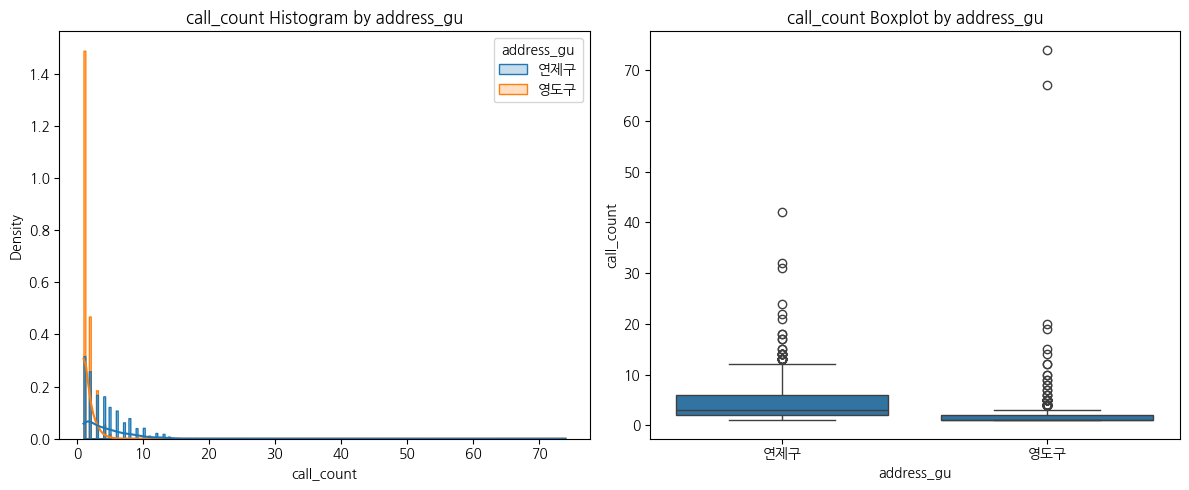

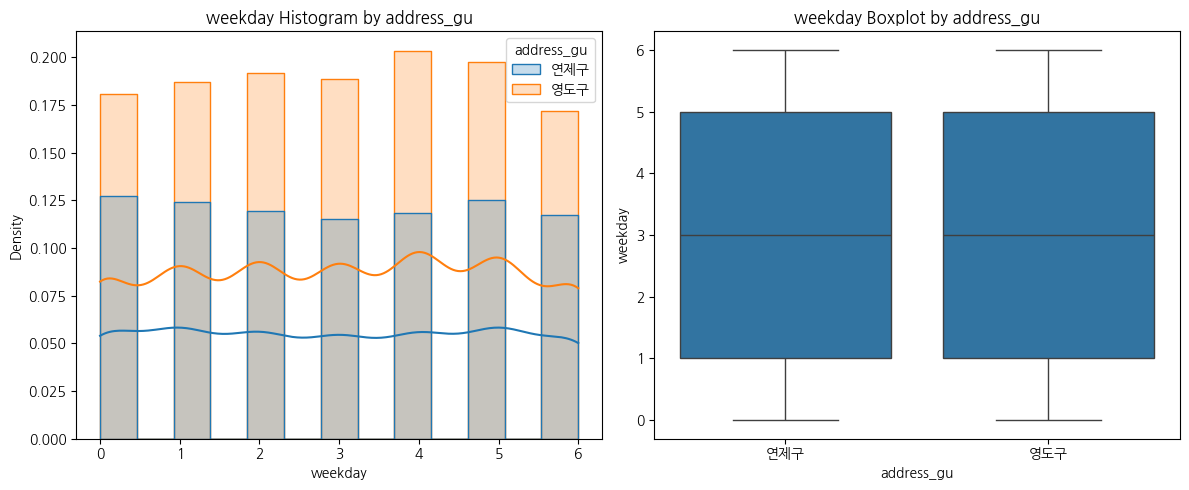

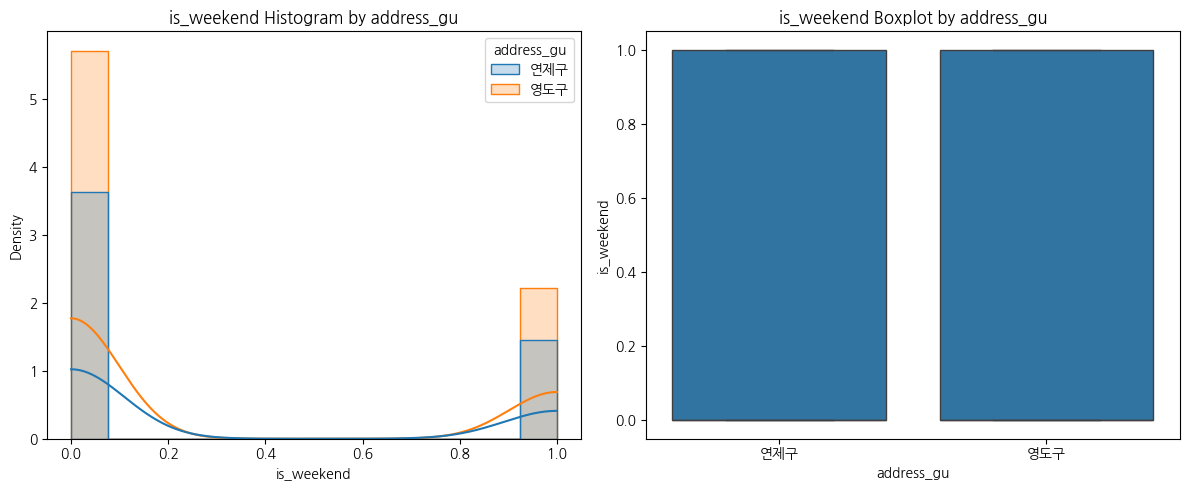

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/기상청/최종작업/2020_2023_최종데이터.csv')

# 필터링
target_gu = ['연제구', '영도구']
df_filtered = df[df['address_gu'].isin(target_gu)].copy()

# 파생 변수
df_filtered['weekday'] = pd.to_datetime(df_filtered['tm'], format='%Y%m%d').dt.weekday
df_filtered['is_weekend'] = df_filtered['weekday'].isin([5, 6]).astype(int)

# 실제 존재하는 컬럼만 추림
all_features = ['call_count', 'temp', 'rainfall', 'wind_speed', 'humidity', 'weekday', 'is_weekend']
existing_features = [col for col in all_features if col in df_filtered.columns]

# 시각화
for feature in existing_features:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(data=df_filtered, x=feature, hue='address_gu', kde=True, element='step', stat='density')
    plt.title(f'{feature} Histogram by address_gu')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df_filtered, x='address_gu', y=feature)
    plt.title(f'{feature} Boxplot by address_gu')

    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from tqdm import tqdm

# 1. 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/기상청/최종작업/2020_2023_최종데이터.csv')

# 2. tm_dt 제거
if 'tm_dt' in df.columns:
    df.drop(columns=['tm_dt'], inplace=True)

# 3. 날짜 파생 변수
df['year'] = df['tm'] // 10000
df['month'] = (df['tm'] % 10000) // 100
df['day'] = df['tm'] % 100
df['weekday'] = pd.to_datetime(df['tm'], format='%Y%m%d').dt.weekday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
df['is_before_holiday'] = df['공휴일'].shift(-1, fill_value=0)
df['is_after_holiday'] = df['공휴일'].shift(1, fill_value=0)

# 4. 범주형 인코딩
encoder = LabelEncoder()
df['address_city'] = encoder.fit_transform(df['address_city'])

# 5. 평균 타겟 인코딩
df['address_gu_mean_target'] = df.groupby('address_gu')['call_count'].transform('mean')
df['sub_address_mean_target'] = df.groupby('sub_address')['call_count'].transform('mean')

# 6. address_gu 정보 따로 저장
address_gu_all = df['address_gu'].copy()  # ✅ 보존

# 7. 입력/출력 구성 (이제 address_gu는 제거!)
drop_cols = ['tm', 'call_count', 'address_gu', 'sub_address']
X = df.drop(columns=drop_cols)
y = df['call_count']

# 8. float32 변환
X = X.astype('float32')
y = y.astype('float32')

# 9. 학습/검증 분리 (address_gu 함께 나눔)
X_train, X_val, y_train, y_val, gu_train, gu_val = train_test_split(
    X, y, address_gu_all, test_size=0.2, random_state=42
)

# 10. 구별 모델 학습
gu_models = {}
gu_scores = {}

gu_list = gu_train.unique()

for gu in gu_list:
    X_train_gu = X_train[gu_train == gu]
    y_train_gu = y_train[gu_train == gu]
    X_val_gu = X_val[gu_val == gu]
    y_val_gu = y_val[gu_val == gu]

    if len(X_train_gu) < 30:
        print(f"⚠️ {gu} - 데이터 수 부족으로 학습 생략")
        continue

    model = XGBRegressor(
      n_estimators=300,
      max_depth=6,
      learning_rate=0.05,
      subsample=0.8,
      colsample_bytree=0.8,
      tree_method='hist',
      random_state=42,
      early_stopping_rounds=30
      )
    model.fit(
      X_train, y_train,
      eval_set=[(X_val_gu, y_val_gu)],
      verbose=False
      )

    y_pred_val = model.predict(X_val_gu)
    rmse = np.sqrt(mean_squared_error(y_val_gu, y_pred_val))

    gu_models[gu] = model
    gu_scores[gu] = rmse

    print(f"✅ [{gu}] RMSE: {rmse:.4f}")

# 11. 전체 검증 RMSE 출력
all_preds = []
all_targets = []

for gu in gu_models.keys():
    X_val_gu = X_val[gu_val == gu]
    y_val_gu = y_val[gu_val == gu]
    y_pred_val = gu_models[gu].predict(X_val_gu)

    all_preds.extend(y_pred_val)
    all_targets.extend(y_val_gu)

total_rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
print(f"\n📊 전체 RMSE (call_count 기준): {total_rmse:.4f}")

✅ [해운대구] RMSE: 1.6463
✅ [사하구] RMSE: 1.3394
✅ [금정구] RMSE: 1.0098
✅ [북구] RMSE: 1.4789
✅ [기장군] RMSE: 1.2671
✅ [동구] RMSE: 1.4908
✅ [사상구] RMSE: 0.9830
✅ [부산진구] RMSE: 1.2608
✅ [남구] RMSE: 1.9850
✅ [연제구] RMSE: 3.8011
✅ [강서구] RMSE: 0.7617
✅ [수영구] RMSE: 1.2636
✅ [동래구] RMSE: 1.5803
✅ [중구] RMSE: 0.7104
✅ [영도구] RMSE: 3.6719
✅ [서구] RMSE: 0.7330

📊 전체 RMSE (call_count 기준): 1.3381


In [ ]:
# 예측
valid_df = pd.read_csv('/content/drive/MyDrive/기상청/최종작업/2024_최종데이터.csv')
result_df_list = []

# 평균값 매핑 저장
address_gu_mean_map = df.groupby('address_gu')['call_count'].mean().to_dict()
sub_address_mean_map = df.groupby('sub_address')['call_count'].mean().to_dict()

for gu in tqdm(valid_df['address_gu'].unique()):
    if gu not in gu_models:
        print(f"⚠️ {gu} 모델 없음 → 예측 생략")
        continue

    valid_gu_df = valid_df[valid_df['address_gu'] == gu].copy()
    valid_gu_df['year'] = valid_gu_df['tm'] // 10000
    valid_gu_df['month'] = (valid_gu_df['tm'] % 10000) // 100
    valid_gu_df['day'] = valid_gu_df['tm'] % 100
    valid_gu_df['weekday'] = pd.to_datetime(valid_gu_df['tm'], format='%Y%m%d').dt.weekday
    valid_gu_df['is_weekend'] = valid_gu_df['weekday'].isin([5, 6]).astype(int)
    valid_gu_df['is_before_holiday'] = valid_gu_df['공휴일'].shift(-1, fill_value=0)
    valid_gu_df['is_after_holiday'] = valid_gu_df['공휴일'].shift(1, fill_value=0)

    valid_gu_df['address_city'] = valid_gu_df['address_city'].apply(
        lambda x: x if x in encoder.classes_ else 'Unknown'
    )
    if 'Unknown' not in encoder.classes_:
        encoder.classes_ = np.append(encoder.classes_, 'Unknown')
    valid_gu_df['address_city'] = encoder.transform(valid_gu_df['address_city'])

    valid_gu_df['address_gu_mean_target'] = address_gu_mean_map.get(gu, df['call_count'].mean())
    valid_gu_df['sub_address_mean_target'] = valid_gu_df['sub_address'].map(sub_address_mean_map)
    valid_gu_df['sub_address_mean_target'] = valid_gu_df['sub_address_mean_target'].fillna(df['call_count'].mean())

    X_valid_gu = valid_gu_df.drop(columns=['tm', 'call_count', 'address_gu', 'sub_address'], errors='ignore')
    for col in X.columns:
        if col not in X_valid_gu.columns:
            X_valid_gu[col] = 0.0
    X_valid_gu = X_valid_gu[X.columns].astype('float32')

    preds = np.round(gu_models[gu].predict(X_valid_gu)).astype(int)
    valid_gu_df['call_count'] = preds

    result_df_list.append(valid_gu_df[['tm', 'address_city', 'address_gu', 'sub_address', 'call_count']])

# 병합
valid_preds_df = pd.concat(result_df_list, ignore_index=True)
valid_preds_df.rename(columns={'tm': 'TM'}, inplace=True)

submission_template = pd.read_csv('/content/drive/MyDrive/기상청/최종작업/test_call119.csv', encoding='euc-kr')
submission_template['address_city'] = submission_template['address_city'].apply(
    lambda x: x if x in encoder.classes_ else 'Unknown'
)
if 'Unknown' not in encoder.classes_:
    encoder.classes_ = np.append(encoder.classes_, 'Unknown')
submission_template['address_city'] = encoder.transform(submission_template['address_city'])

submission_template.drop(columns=['call_count'], inplace=True, errors='ignore')

submission = submission_template.merge(
    valid_preds_df,
    on=['TM', 'address_city', 'address_gu', 'sub_address'],
    how='left'
)

submission['call_count'] = submission['call_count'].fillna(0).astype(int)
submission.to_csv('250028.csv', index=False, encoding='cp949')
print("✅ 제출 파일 저장 완료: 250028.csv")

# 예측 분포 확인
print(submission['call_count'].value_counts().sort_index())

100%|██████████| 16/16 [00:00<00:00, 49.41it/s]


✅ 제출 파일 저장 완료: 250028.csv
call_count
1    3402
2    5211
3     704
4      93
5      42
6      78
7      49
8      17
9       5
Name: count, dtype: int64


In [ ]:
submission['call_count'].value_counts()

,count
call_count,
2,5211
1,3402
3,704
4,93
6,78
7,49
5,42
8,17
9,5
